In [60]:
%matplotlib inline

In [61]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, ttest_ind
import pandas as pd
import numpy as np
import os

In [62]:
# Imports from FinanceOps.
from data_keys import *
from data import load_usa_cpi, _resample_daily

In [63]:
# House Price Index (HPI).
HPI = "HPI"
HPI_REAL = "HPI (Real)"
#Exact House Price 
HP = "HP"
RATIO_EXACT = "Dollar / Earnings"
# Weekly earnings, nominal and real.
EARNINGS = "Earnings"
EARNINGS_REAL = "Earnings (Real)"

# Annual growth in weekly earnings, nominal and real.
EARNINGS_GROWTH = "Earnings Growth"
EARNINGS_GROWTH_REAL = "Earnings Growth (Real)"

# Valuation ratio for HPI / Earnings.
RATIO = "HPI/Earnings"

# Valuation ratio for Mortgage Factor x HPI / Earnings.
RATIO_MF = "MF x HPI/Earnings"

# Annualized Return, nominal and real.
ANN_RETURN = "Ann. Return"
ANN_RETURN_REAL = "Ann. Return (Real)"

# Mortgage rate.
MORTGAGE_RATE = "Mortgage Rate 30-Year"

# Mortgage factor.
MORTGAGE_FACTOR = "Mortgage Factor"

In [64]:
# Directory where the data-files are located.
data_dir = "data/"

def _load_data(filename, new_name=None):
    """
    Load a CSV-file with comma-separation.
    Dates are in the first column with format MM/DD/YYYY.

    This is a simple wrapper for Pandas.read_csv().

    :param filename: Filename for the data-file.
    :param new_name: (Optional) string with new data-name.
    :return: Pandas DataFrame or Series.
    """

    # Path for the data-file.
    path = path = os.path.join(data_dir, filename)

    # Load data.
    data = pd.read_csv(path,
                       sep=",",
                       index_col=0,
                       parse_dates=True,
                       dayfirst=False,
                       squeeze=True)

    # Rename data column.
    if new_name is not None:
        data = data.rename(new_name)
    
    return data

In [65]:
# Load Consumer Price Index (CPI).
df_CPI = load_usa_cpi()

In [66]:
# Exact House Price
filename = "USA House Price.csv"
df_HP = _load_data(filename=filename, new_name=HP)

C:\Users\wiadmin\AppData\Local\Temp\ipykernel_15896\686769031.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv(path,


In [67]:
# Load House Price Index (HPI).
filename = "USA House Price Index.csv"
df_HPI = _load_data(filename=filename, new_name=HPI)

C:\Users\wiadmin\AppData\Local\Temp\ipykernel_15896\686769031.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv(path,


In [68]:
# Load Weekly Earnings (Nominal).
filename = "USA Median Weekly Nominal Earnings.csv"
df_earnings = _load_data(filename=filename, new_name=EARNINGS)

C:\Users\wiadmin\AppData\Local\Temp\ipykernel_15896\686769031.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv(path,


In [69]:
# Load Weekly Earnings (Real).
filename = "USA Median Weekly Real Earnings.csv"
df_earnings_real = _load_data(filename=filename, new_name=EARNINGS_REAL)

C:\Users\wiadmin\AppData\Local\Temp\ipykernel_15896\686769031.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv(path,


In [70]:
# Load Mortgage Rate 30-Year and resample to daily data.
filename = "USA Mortgage Rate 30-Year.csv"
df_mortgage_rate = _load_data(filename=filename, new_name=MORTGAGE_RATE)
df_mortgage_rate /= 100.0
df_mortgage_rate = _resample_daily(df_mortgage_rate)

C:\Users\wiadmin\AppData\Local\Temp\ipykernel_15896\686769031.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv(path,


In [71]:
# Combine the time-series into a single DataFrame.
dfs = [df_HPI, df_earnings, df_earnings_real,
       df_CPI, df_mortgage_rate]
df = pd.concat(dfs, axis=1)
df = df.dropna()
df

,HPI,Earnings,Earnings (Real),CPI,Mortgage Rate 30-Year
Date,,,,,
1979-01-01,91.38,234.0,335.0,68.300,0.103800
1979-04-01,94.37,239.0,335.0,70.600,0.104586
1979-07-01,96.38,240.0,330.0,73.100,0.111086
1979-10-01,98.29,249.0,326.0,75.200,0.113500
1980-01-01,100.00,256.0,321.0,77.800,0.128714
...,...,...,...,...,...
2017-10-01,407.67,857.0,345.0,246.663,0.038386
2018-01-01,413.53,881.0,350.0,247.867,0.039671
2018-04-01,423.91,876.0,351.0,250.546,0.044229


In [72]:
# Inflation-adjusted (real) House Price Index (HPI).
df[HPI_REAL] = df[HPI] / df[CPI]

In [73]:
# Calculate the Mortgage Factor.
years = 30
df[MORTGAGE_FACTOR] = years * df_mortgage_rate / (1 - 1 / (1 + df_mortgage_rate) ** years)

In [74]:
# Calculate growth in personal earnings (income, wages).
# Assume the data is quarterly.
periods=4
df[EARNINGS_GROWTH] = df[EARNINGS].pct_change(periods=periods)
df[EARNINGS_GROWTH_REAL] = df[EARNINGS_REAL].pct_change(periods=periods)

In [75]:
# Valuation ratio: HPI / Personal Earnings
df[RATIO] = df[HPI] / df[EARNINGS]

# Valuation ratio: Mortgage Factor x HPI / Personal Earnings
df[RATIO_MF] = df[MORTGAGE_FACTOR] * df[HPI] / df[EARNINGS_REAL]

In [76]:
def prepare_ann_returns(df, years):
    """
    Calculate the annualized return on the House Price Index (HPI)
    and add the data-columns to the DataFrame `df` with
    keys ANN_RETURN and ANN_RETURN_REAL.
    
    :param df:
        Pandas DataFrame with columns named HPI and HPI_REAL.
        Assume the data is quarterly.

    :param years:
        Number of years for the annualized returns.

    :return:
        None. The DataFrame `df` is updated.
    """

    # Number of quarters corresponding to the number of years.
    quarters = 4 * years

    # Nominal annualized return for the HPI.
    df[ANN_RETURN] = (df[HPI].shift(-quarters) / df[HPI]) ** (1/years) - 1

    # Real (inflation-adjusted) annualized return for the HPI.
    df[ANN_RETURN_REAL] = (df[HPI_REAL].shift(-quarters) / df[HPI_REAL]) ** (1/years) - 1

In [77]:
df.head()

,HPI,Earnings,Earnings (Real),CPI,Mortgage Rate 30-Year,HPI (Real),Mortgage Factor,Earnings Growth,Earnings Growth (Real),HPI/Earnings,MF x HPI/Earnings
Date,,,,,,,,,,,
1979-01-01,91.38,234.0,335.0,68.3,0.103800,1.337921,3.283688,NaN,NaN,0.390513,0.895712
1979-04-01,94.37,239.0,335.0,70.6,0.104586,1.336686,3.304740,NaN,NaN,0.394854,0.930950
1979-07-01,96.38,240.0,330.0,73.1,0.111086,1.318468,3.480202,NaN,NaN,0.401583,1.016430
1979-10-01,98.29,249.0,326.0,75.2,0.113500,1.307048,3.545937,NaN,NaN,0.394739,1.069111
1980-01-01,100.00,256.0,321.0,77.8,0.128714,1.285347,3.966352,0.094017,-0.041791,0.390625,1.235624


<AxesSubplot: xlabel='Date'>

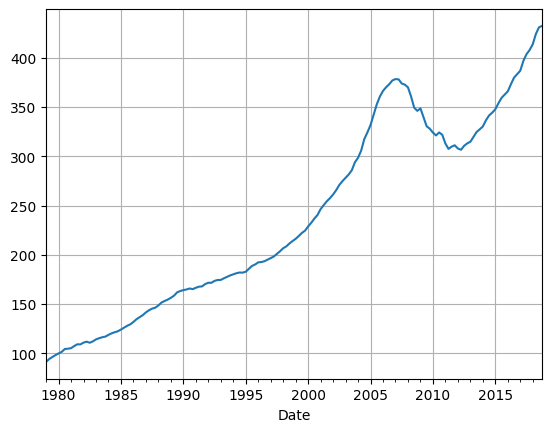

In [78]:
df[HPI].plot(grid=True)

<AxesSubplot: xlabel='Date'>

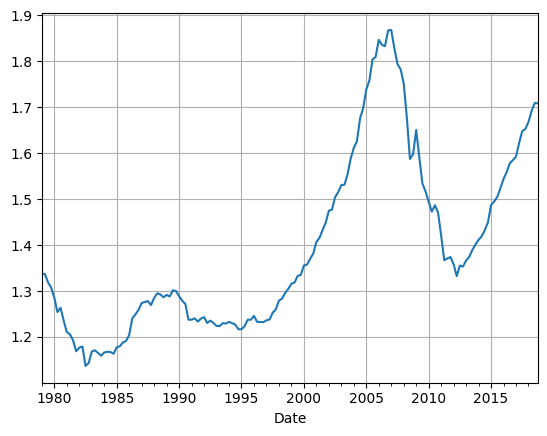

In [79]:
df[HPI_REAL].plot(grid=True)

<AxesSubplot: xlabel='Date'>

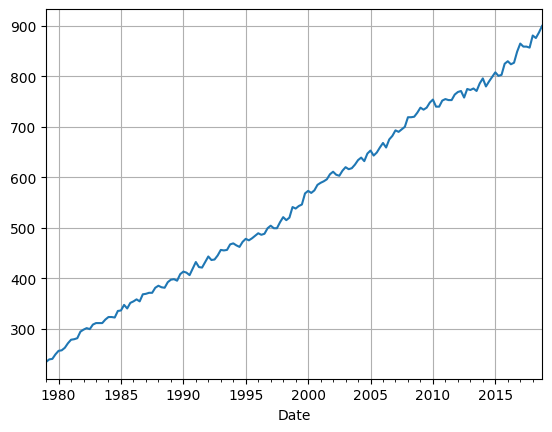

In [80]:
df[EARNINGS].plot(grid=True)

<AxesSubplot: xlabel='Date'>

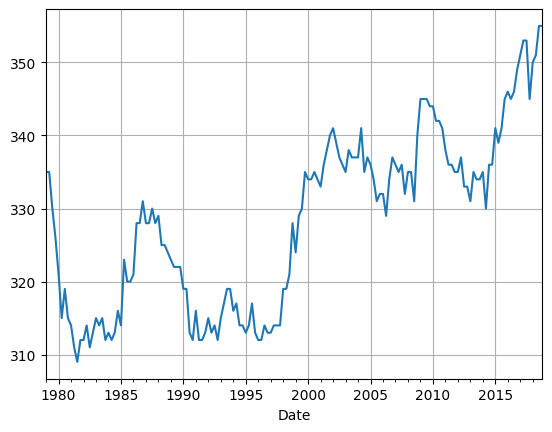

In [81]:
df[EARNINGS_REAL].plot(grid=True)

<AxesSubplot: xlabel='Date'>

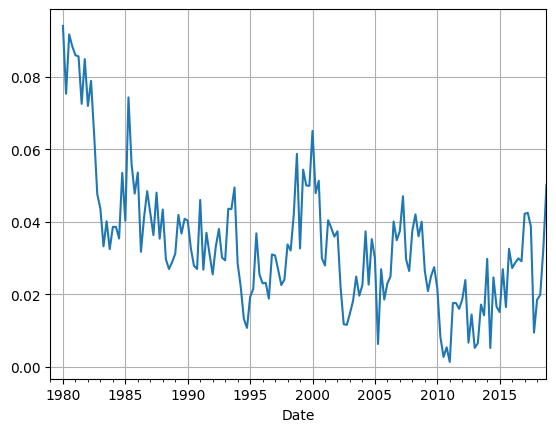

In [82]:
df[EARNINGS_GROWTH].plot(grid=True)

In [83]:
df[EARNINGS_GROWTH].describe()

count    156.000000
mean       0.034167
std        0.018377
min        0.001326
25%        0.022635
50%        0.031098
75%        0.041921
max        0.094017
Name: Earnings Growth, dtype: float64

In [84]:
df[EARNINGS_GROWTH_REAL].describe()

count    156.000000
mean       0.001733
std        0.016654
min       -0.059701
25%       -0.009231
50%        0.000000
75%        0.013259
max        0.044586
Name: Earnings Growth (Real), dtype: float64

<AxesSubplot: xlabel='Date'>

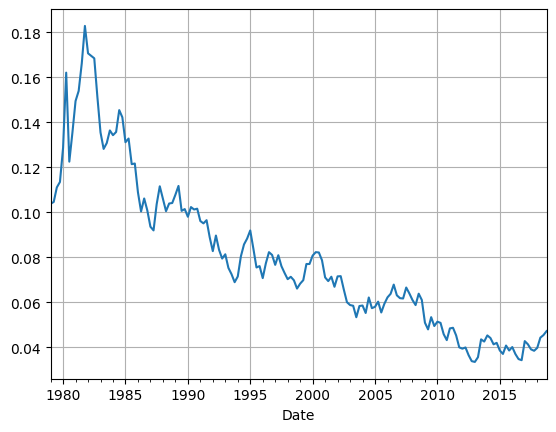

In [85]:
df[MORTGAGE_RATE].plot(grid=True)

<AxesSubplot: xlabel='Date'>

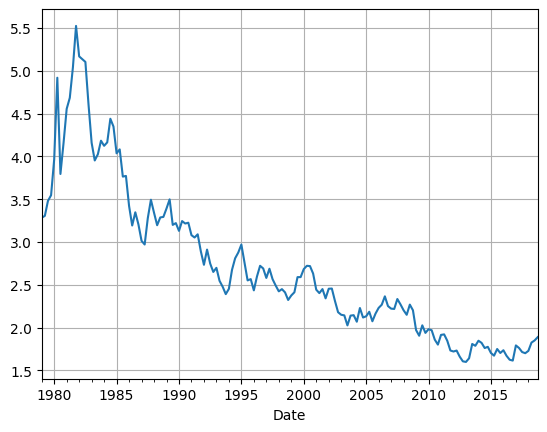

In [86]:
df[MORTGAGE_FACTOR].plot(grid=True)

<AxesSubplot: xlabel='Mortgage Rate 30-Year', ylabel='Mortgage Factor'>

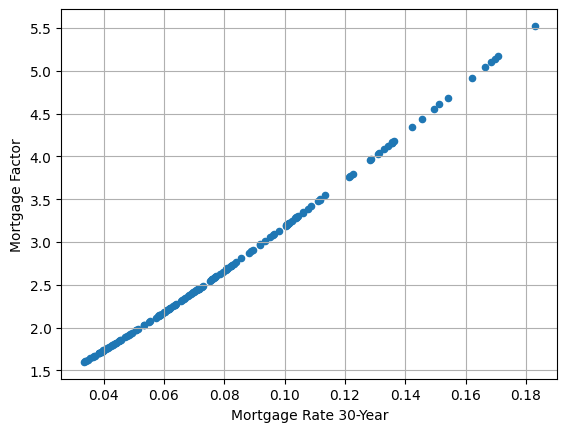

In [87]:
df.plot(kind='scatter', grid=True,
        x=MORTGAGE_RATE, y=MORTGAGE_FACTOR)

<AxesSubplot: xlabel='Date'>

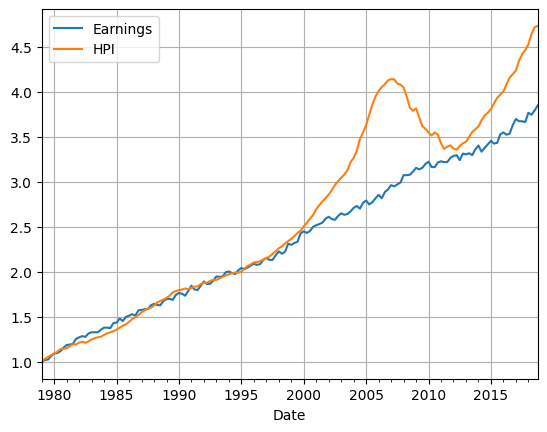

In [88]:
# Compare Earnings and HPI.
# Normalize to start at 1.0
df2 = df[[EARNINGS, HPI]].dropna()
df2 /= df2.values[0]
df2.plot(grid=True)

<AxesSubplot: title={'center': 'HPI / Earnings'}, xlabel='Date'>

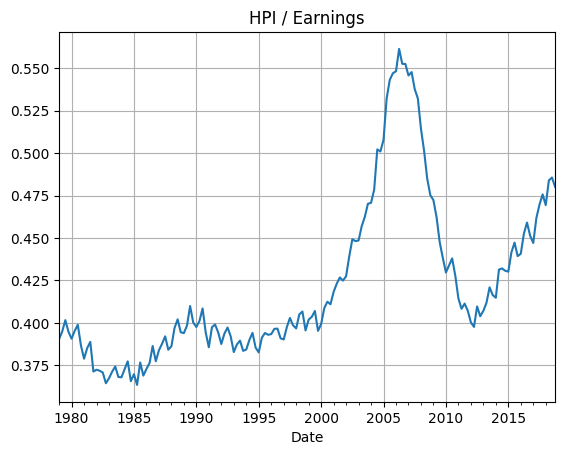

In [89]:
df[RATIO].plot(title="HPI / Earnings", grid=True)

In [90]:
df[RATIO].describe()

count    160.000000
mean       0.421818
std        0.047902
min        0.363401
25%        0.390434
50%        0.402467
75%        0.447116
max        0.561426
Name: HPI/Earnings, dtype: float64

In [95]:
# Update the DataFrame with annualized returns.
prepare_ann_returns(df=df, years=10)

<AxesSubplot: title={'center': 'HPI Annualized Returns (Nominal)'}, xlabel='Date'>

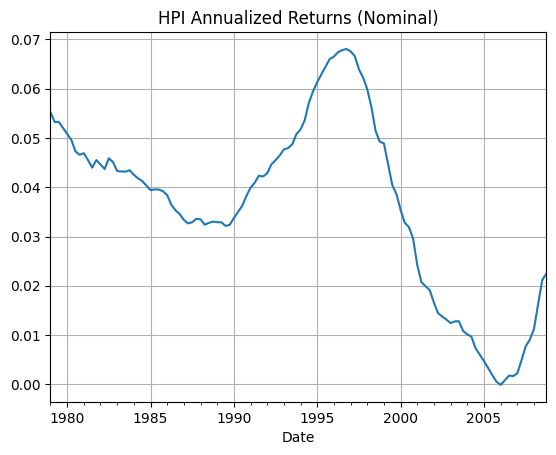

In [96]:
title = "HPI Annualized Returns (Nominal)"
df[ANN_RETURN].dropna().plot(title=title, grid=True)

In [97]:
df[RATIO_MF].describe()

count    160.000000
mean       1.738685
std        0.314817
min        0.895712
25%        1.563832
50%        1.701015
75%        1.855172
max        2.641518
Name: MF x HPI/Earnings, dtype: float64

In [98]:
# Update the DataFrame with annualized returns.
prepare_ann_returns(df=df, years=10)

<AxesSubplot: title={'center': 'HPI Annualized Returns (Real)'}, xlabel='Date'>

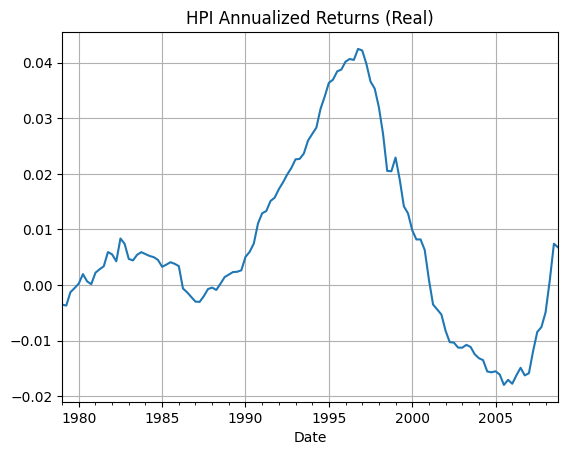

In [99]:
title = "HPI Annualized Returns (Real)"
df[ANN_RETURN_REAL].dropna().plot(title=title, grid=True)

In [100]:
def plot_valuation_vs_returns(use_mortgage_factor=False,
                              use_real_returns=False):
    """
    Make a scatter-plot with the Valuation Ratio on the x-axis
    and the Annualized Returns on the y-axis.
    
    :param use_mortgage_factor: Boolean whether to use the
                                Mortgage Factor in the Val. Ratio.
    :param use_real_returns: Boolean whether to use Real (True)
                             or Nominal (False) ann. returns.
    :return: Matplotlib Axes.
    """

    # Use Mortgage Factor?
    if use_mortgage_factor:
        x_key = RATIO_MF
    else:
        x_key = RATIO

    # Use Real Returns?
    if use_real_returns:
        y_key = ANN_RETURN_REAL
    else:
        y_key = ANN_RETURN
    
    # Create a figure.
    # Necessary because of a bug in either Pandas or Jupyter?
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Create the plot.
    axes = df.plot(kind='scatter', x=x_key, y=y_key,
                   c=MORTGAGE_RATE, cmap='rainbow',
                   grid=True, ax=ax)
    
    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    return axes

In [101]:
# Update the DataFrame with annualized returns.
prepare_ann_returns(df=df, years=10)

<AxesSubplot: xlabel='HPI/Earnings', ylabel='Ann. Return'>

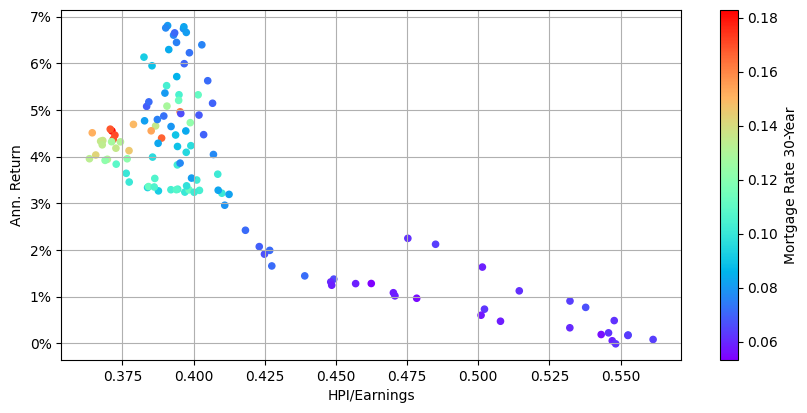

In [102]:
plot_valuation_vs_returns(use_mortgage_factor=False,
                          use_real_returns=False)

In [103]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term returns on
    a House Price Index (HPI) using a valuation ratio such
    as HPI / Personal Earnings.
    """

    def __init__(self, df, years,
                 use_mortgage_factor=False,
                 use_real_returns=False,
                 mean_valuation_ratio=None,
                 mean_earnings_growth=None):
        """
        Create a new model and fit it with the given data.

        :param df:
            Pandas DataFrame with required data.

        :param years:
            Number of years to forecast.

        :param use_mortgage_factor:
            Boolean for which valuation ratio to use:
            HPI/Earnings (False) or MF * HPI/Earnings (True).

        :param use_real_returns:
            Boolean whether to use nominal returns (False) or
            real / inflation-adjusted returns (True). Also
            toggles between real and nominal earnings growth.
            
        :param mean_valuation_ratio:
            (Optional) Use this mean valuation ratio instead
            of the mean from the data in `df`.

        :param mean_earnings_growth:
            (Optional) Use this mean earnings growth instead
            of the mean from the data in `df`.
        """

        # Copy args to self.
        self.years = years

        # Use real or nominal returns and earnings growth?
        if use_real_returns:
            # Keys to use real data from the DataFrame.
            ann_return = ANN_RETURN_REAL
            earnings_growth = EARNINGS_GROWTH_REAL
        else:
            # Keys to use nominal data from the DataFrame.
            ann_return = ANN_RETURN
            earnings_growth = EARNINGS_GROWTH
        
        # Use the Mortgage Factor in the valuation ratio?
        if use_mortgage_factor:
            # Key to use valuation ratio: MF * HPI/Earnings
            ratio = RATIO_MF
        else:
            # Key to use valuation ratio: HPI/Earnings
            ratio = RATIO

        # Optional override of the mean valuation ratio.
        if mean_valuation_ratio is None:
            # Use mean valuation ratio from the supplied data.
            mean_valuation_ratio = np.mean(df[ratio] ** (1.0/years))
        else:
            # Override the mean valuation ratio.
            # Note: Due to Jensen's Inequality, this is not
            # identical to mean(df[ratio] ** (1.0/years)) even
            # if mean_valuation_ratio == mean(df[ratio]).
            mean_valuation_ratio = mean_valuation_ratio ** (1.0/years)

        # Use mean earnings growth from the supplied data?
        if mean_earnings_growth is None:
            mean_earnings_growth = np.mean(df[earnings_growth])

        # Add 1.0 to the mean earnings growth.
        mean_earnings_growth += 1.0

        # Calculate the `a` parameter for the mean ann.return.
        self.a = mean_valuation_ratio * mean_earnings_growth

        # Calculate the `b` parameter for the std.dev. ann.return.
        # This is an estimate. Another way of estimating it would be
        # using Monte Carlo simulation.
        self.b = np.std(df[ratio] ** (1/years) * (1 + df[earnings_growth]))

    def forecast(self, ratio_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future HPI returns.
        
        :param ratio_t: Array with different valuation ratios at start-time t.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the ratio_t values.
        """

        # Annualized ratio_t which is used in both formulas.
        ratio_ann = ratio_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of valuation ratios.
        mean = self.a / ratio_ann - 1.0
        std = self.b / ratio_ann

        return mean, std
    
    def _ttest(self, err_forecast, err_baseline):
        """
        Perform a t-test on the residual errors of the
        forecasting model and the baseline to assess whether
        their means are equal.
        
        When the resulting p_value is close to zero, the means
        are unlikely to be equal.
        
        :param err_forecast:
            Residual errors for the forecasting model.

        :param err_baseline:
            Residual errors for the baseline.

        :return:
            p_value
        """
        
        if True:
            # Paired t-test.
            t_value, p_value = ttest_rel(a=err_forecast, b=err_baseline)
        else:
            # Un-paired / independent t-test.
            t_value, p_value = ttest_ind(a=err_forecast, b=err_baseline, equal_var=False)

        return p_value

    def MAE(self, ratio_t, ann_rets):
        """
        Calculates the Mean Absolute Error (MAE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MAE between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAE values are equal.
        
        :param ratio_t:
            Array with different valuation ratios at start-time t.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAE between model's forecast and actual returns.
            mae_baseline: MAE between baseline and actual returns.
            p_value: p-value whether the two MAE values are equal.
        """

        # Forecast the mean and std.dev. for the HPI returns,
        # from the historical valuation ratios.
        mean_forecast, std_forecast = self.forecast(ratio_t=ratio_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast)
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets))
        
        # Mean Absolute Errors (MAE).
        mae_forecast = np.mean(err_forecast)
        mae_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mae_forecast, mae_baseline, p_value
    
    def R_squared(self, ratio_t, ann_rets):
        """
        Calculate the Coefficient of Determination R^2 for
        measuring the Goodness of Fit between the forecasted
        mean and the observed annualized returns.

        An R^2 value of 1 means there is a perfect fit and
        the forecasting model explains all of the variance
        in the data. An R^2 value of zero means the forecasting
        model does not explain any of the variance in the data.
        
        Note that because the forecasting model is non-linear,
        the R^2 can become negative if the model fits poorly
        on data with a large variance.

        :param ratio_t:
            Array with different valuation ratios at start-time t.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            R^2 value.
        """

        # Forecast the mean and std.dev. for the HPI returns,
        # from the historical valuation ratios.
        mean_forecast, std_forecast = self.forecast(ratio_t=ratio_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Sum of Squared Errors (SSE) for the forecasting model.
        sse = np.sum(err_forecast)
        
        # Sum of Squared Errors (SST) for the baseline.
        sst = np.sum(err_baseline)

        # The R^2 value.
        R_squared = 1.0 - sse / sst
        
        return R_squared

In [104]:
def print_statistics(model, ratio_t, ann_rets):
    """
    Calculate and print the Goodness of Fit statistics
    for a model's forecast compared to the baseline.

    The p-value results from a paired t-test whether
    the values are equal. A p-value close to zero means
    that the values are unlikely to be equal.

    :param model:
        Instance of the ForecastModel class.

    :param ratio_t:
        Array with different valuation ratios at start-time.

    :param ann_rets:
        Array with the corresponding annualized returns.
    """
    
    # Print header.
    print("\tForecast\tBaseline\tp-value")
    print("=================================================")

    # Mean Absolute Error (MAE).
    mae_forecast, mae_baseline, p_value = model.MAE(ratio_t=ratio_t,
                                                    ann_rets=ann_rets)
    msg = "MAE:\t{0:.1%}\t\t{1:.1%}\t\t{2:.2e}"
    msg = msg.format(mae_forecast, mae_baseline, p_value)
    print(msg)

    # R^2.
    R_squared = model.R_squared(ratio_t=ratio_t,
                                ann_rets=ann_rets)
    msg = "R^2:\t{0:.2f}"
    msg = msg.format(R_squared)
    print(msg)

In [105]:
def plot(df, years,
         use_mortgage_factor=False,
         use_real_returns=False,
         mean_valuation_ratio=None,
         mean_earnings_growth=None):
    """
    Make a scatter-plot with the historical data for the
    valuation ratio and annualized returns. Overlay this plot
    with the forecasting model's mean and standard deviation.
    
    :param df:
        Pandas DataFrame with required data.

    :param years:
        Number of years to forecast.

    :param use_mortgage_factor:
        Boolean for which valuation ratio to use:
        HPI/Earnings (False) or MF * HPI/Earnings (True).

    :param use_real_returns:
        Boolean whether to use nominal returns (False) or
        real / inflation-adjusted returns (True). Also
        toggles between real and nominal earnings growth.

    :param mean_valuation_ratio:
        (Optional) Use this mean valuation ratio instead
        of the mean from the data in `df`.

    :param mean_earnings_growth:
        (Optional) Use this mean earnings growth instead
        of the mean from the data in `df`.
    """
    
    # Update the DataFrame with annualized returns.
    prepare_ann_returns(df=df, years=years)

    # Create the forecasting model and fit with historical data.
    model = ForecastModel(df=df, years=years,
                          use_mortgage_factor=use_mortgage_factor,
                          use_real_returns=use_real_returns,
                          mean_valuation_ratio=mean_valuation_ratio,
                          mean_earnings_growth=mean_earnings_growth)

    # Scatter-plot of valuation ratios vs. ann. returns.
    ax = plot_valuation_vs_returns(use_mortgage_factor=use_mortgage_factor,
                                   use_real_returns=use_real_returns)

    # Use real or nominal annualized returns?
    if use_real_returns:
        # Use real / inflation-adjusted ann. returns.
        title_ann_ret = "Ann Return Real"
        ann_ret = ANN_RETURN_REAL
    else:
        # Use nominal ann. returns.
        title_ann_ret = "Ann Return"
        ann_ret = ANN_RETURN
    
    # Use the Mortgage Factor in the valuation ratio?
    if use_mortgage_factor:
        # Valuation ratio is: MF * HPI/Earnings
        title_ratio = "(MF $\cdot$ HPI/Earnings)"
        ratio = RATIO_MF
    else:
        # Valuation ratio is: HPI/Earnings
        title_ratio = "(HPI/Earnings)"
        ratio = RATIO

    # Create array of evenly spread valuation ratios.
    # This is used for the x-axis when plotting the
    # curves of the forecasting model.
    ratio_t = np.linspace(start=df[ratio].min(),
                          stop=df[ratio].max(), num=100)

    # Use the forecasting model to calculate the
    # mean and std.dev. for the annualized returns
    # that correspond to the evenly spread valuation ratios.
    mean, std = model.forecast(ratio_t=ratio_t)

    # Plot the forecasting model's mean ann.return.
    ax.plot(ratio_t, mean, color="black", label="Forecast Mean")

    # Plot one standard deviation around the mean.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(ratio_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(ratio_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(ratio_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)

    # Plot two standard deviations around the mean.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(ratio_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(ratio_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(ratio_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(ratio_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Plot baseline mean as horizontal dashed line.
    ax.axhline(y=df[ann_ret].mean(), color="black", linestyle="--",
               label="Baseline")

    # Show legend.
    ax.legend()
    
    # Create plot-title.
    # First part of the title.
    msg = "{0}-Year {1} for House Price Index (HPI)"
    title1 = msg.format(years, title_ann_ret)
    # Second part of the title. Formula for mean ann. return.
    msg = "E[{0}] = {1:.2f} / ({2} ^ (1/{3})) - 1"
    title2 = msg.format(title_ann_ret, model.a, title_ratio, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[{0}] = {1:.3f} / ({2} ^ (1/{3}))"
    title3 = msg.format(title_ann_ret, model.b, title_ratio, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Show the plot.
    plt.show()

    # Get the historical valuation ratios and ann. returns.
    df2 = df[[ratio, ann_ret]].dropna()
    
    # Print the Goodness of Fit statistics for how well
    # the forecasting model fits the historical data.
    print_statistics(model=model,
                     ratio_t=df2[ratio],
                     ann_rets=df2[ann_ret])

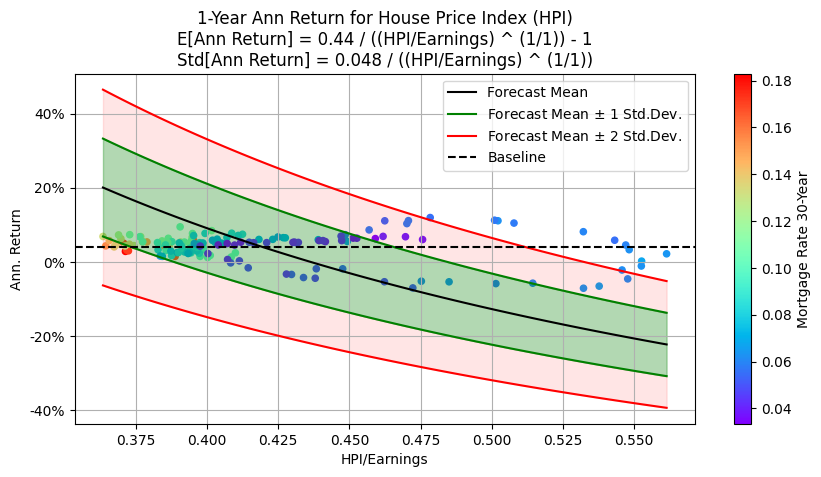

	Forecast	Baseline	p-value
MAE:	8.5%		2.7%		3.49e-23
R^2:	-6.58


In [106]:
plot(df=df, years=1,
     use_mortgage_factor=False,
     use_real_returns=False)

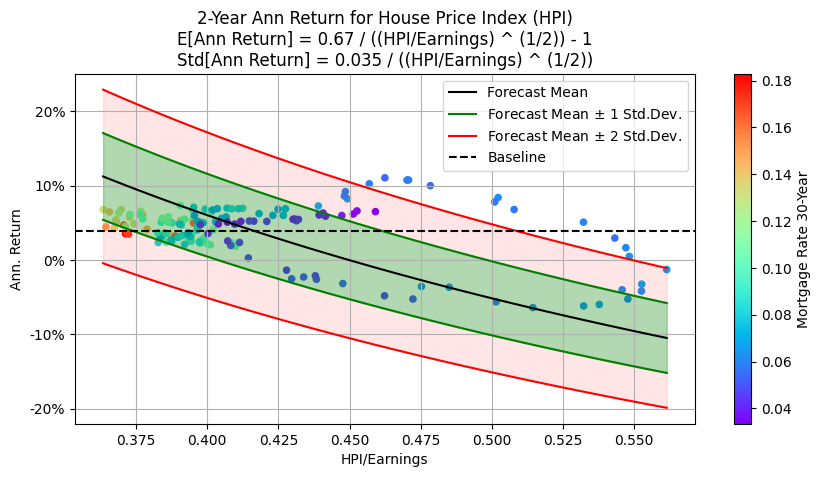

	Forecast	Baseline	p-value
MAE:	4.2%		2.6%		3.44e-07
R^2:	-1.11


In [107]:
plot(df=df, years=2,
     use_mortgage_factor=False,
     use_real_returns=False)

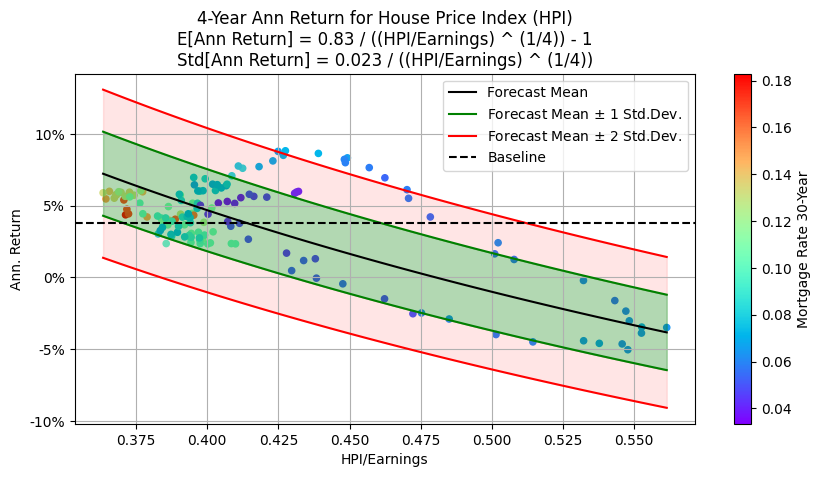

	Forecast	Baseline	p-value
MAE:	2.0%		2.3%		8.40e-02
R^2:	0.37


In [108]:
plot(df=df, years=4,
     use_mortgage_factor=False,
     use_real_returns=False)

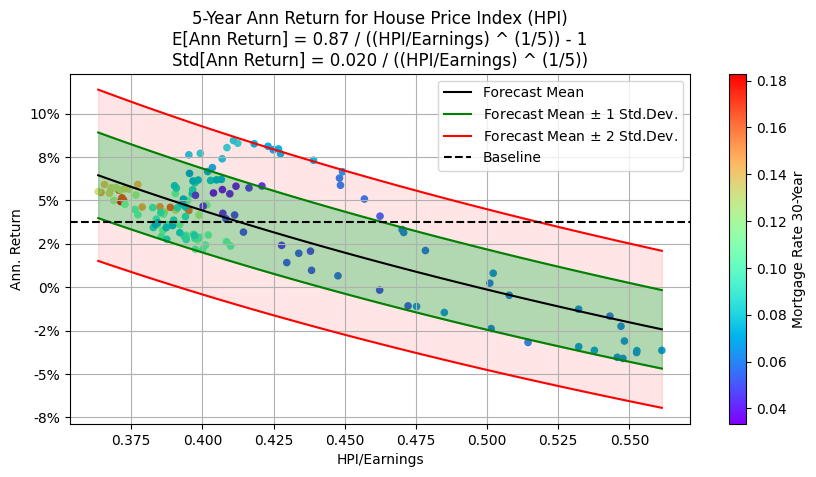

	Forecast	Baseline	p-value
MAE:	1.6%		2.2%		1.16e-04
R^2:	0.55


In [109]:
plot(df=df, years=5,
     use_mortgage_factor=False,
     use_real_returns=False)

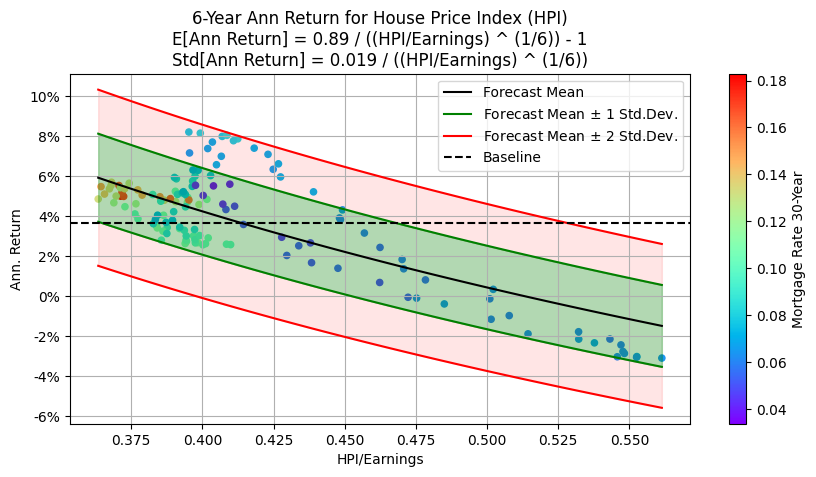

	Forecast	Baseline	p-value
MAE:	1.3%		2.1%		1.32e-07
R^2:	0.63


In [110]:
plot(df=df, years=6,
     use_mortgage_factor=False,
     use_real_returns=False)

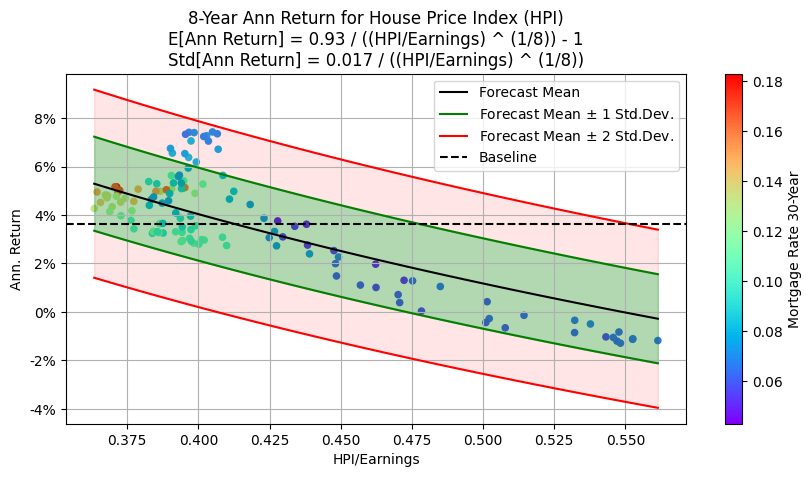

	Forecast	Baseline	p-value
MAE:	1.0%		1.8%		2.04e-10
R^2:	0.65


In [111]:
plot(df=df, years=8,
     use_mortgage_factor=False,
     use_real_returns=False)

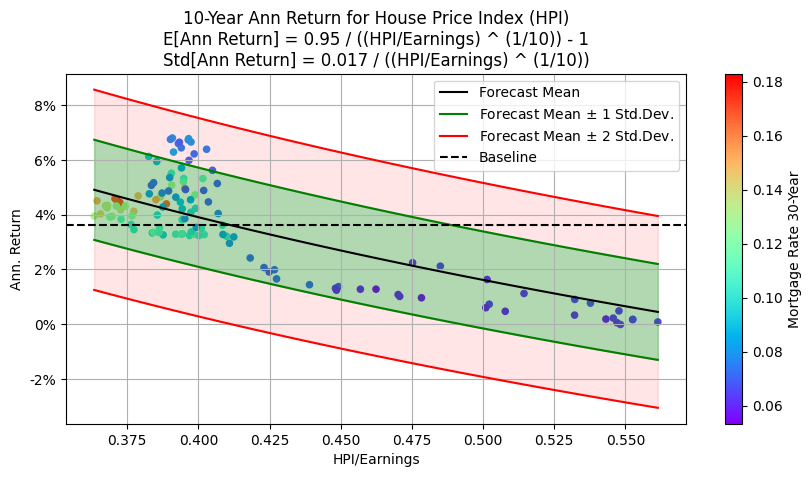

	Forecast	Baseline	p-value
MAE:	0.9%		1.5%		6.74e-10
R^2:	0.62


In [112]:
plot(df=df, years=10,
     use_mortgage_factor=False,
     use_real_returns=False)

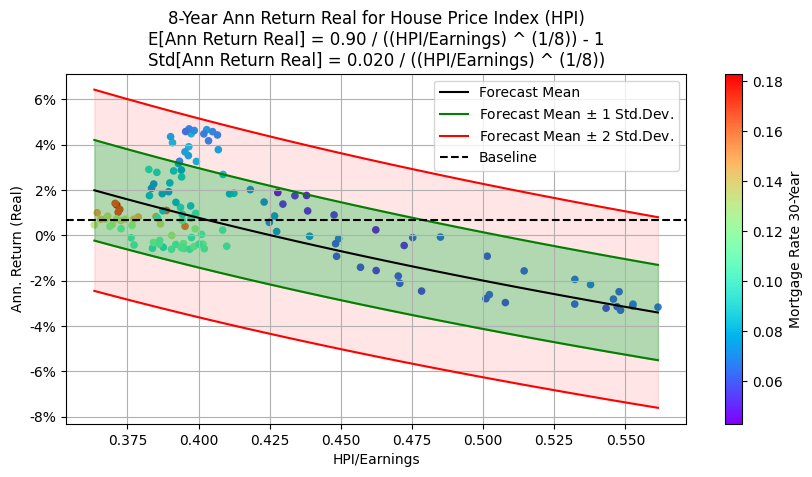

	Forecast	Baseline	p-value
MAE:	1.3%		1.6%		1.30e-02
R^2:	0.36


In [113]:
#Forecasting 8-Year REAL Returns
plot(df=df, years=8,
     use_mortgage_factor=False,
     use_real_returns=True)

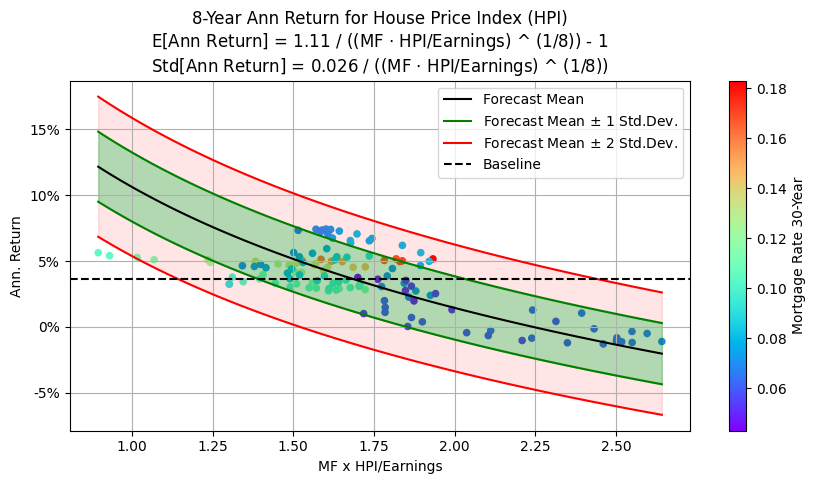

	Forecast	Baseline	p-value
MAE:	1.6%		1.8%		2.35e-01
R^2:	0.20


In [114]:
plot(df=df, years=8,
     use_mortgage_factor=True,
     use_real_returns=False)

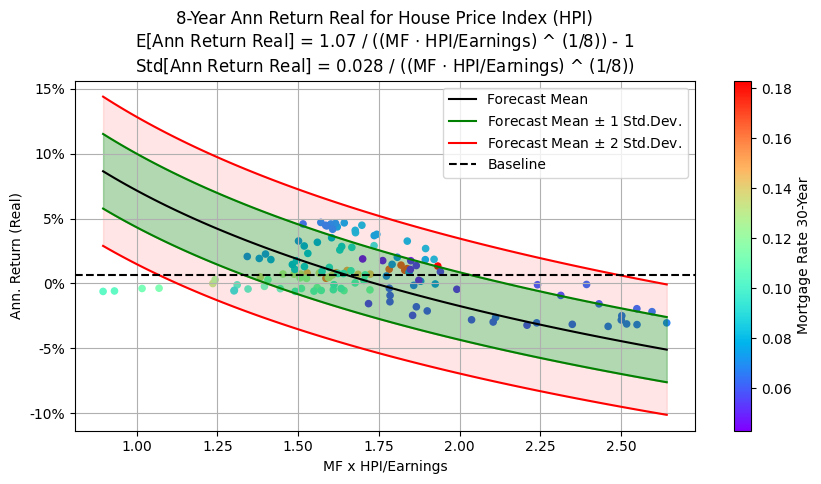

	Forecast	Baseline	p-value
MAE:	2.0%		1.6%		1.03e-02
R^2:	-0.61


In [116]:
plot(df=df, years=8,
     use_mortgage_factor=True,
     use_real_returns=True)